## This notebook shows how to use Orchestrator APIs for user experiments

In [5]:
import os
import json

from fabric_cm.credmgr.credmgr_proxy import CredmgrProxy
from fabric_cf.orchestrator.orchestrator_proxy import OrchestratorProxy

In [6]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
credmgr_proxy = CredmgrProxy(credmgr_host=credmgr_host)
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
orchestrator_proxy = OrchestratorProxy(orchestrator_host=orchestrator_host)

### Fabric Tokens
Fabric has 2 kinds of tokens:<br>
- Identity : required for Control/Measurement Framework APIs. Identity Token is valid upto an hour.
- Refresh : required to generate new Identity Tokens valid. Refresh Token is valid for 24 hours.

Fabric Identity token is required for Control/Measurement Framework APIs.<br>

When user logins to Jupyterhub after authenticating against CILogon, OIDC refresh token is derived. <br>
This token is available as the environment variable `CILOGON_REFRESH_TOKEN`.<br>

On the first login, we use `CILOGON_REFRESH_TOKEN` to generate new Fabric Identity Token and Fabric Refresh Token.<br>
For any subsequent use, we use Fabric Refresh Token. On every refresh, Fabric Refresh Token is changed and updated.<br>

NOTE: These steps are required for any experiments on Fabric Testbed.<br>

In [7]:
not_found=False
fabric_refresh_token=None
%store -r fabric_refresh_token

if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token
print("Fabric Refresh Token {}".format(fabric_refresh_token))
print("CILOGON_REFRESH_TOKEN environment variable: {}".format(os.environ['CILOGON_REFRESH_TOKEN']))

no stored variable or alias fabric_refresh_token
Stored 'fabric_refresh_token' (str)
Fabric Refresh Token https://cilogon.org/oauth2/refreshToken/309331f5a4f913044c5342ba6e68386a/1617115641828
CILOGON_REFRESH_TOKEN environment variable: https://cilogon.org/oauth2/refreshToken/309331f5a4f913044c5342ba6e68386a/1617115641828


### Get new Fabric Identity Token and update Fabric Refresh Token

Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [8]:
try:
    refresh_res = credmgr_proxy.refresh(project_name='all', scope='all', refresh_token=fabric_refresh_token)
    print("New Tokens received: {}".format(json.dumps(refresh_res)))
    fabric_id_token=refresh_res['id_token']
    fabric_refresh_token=refresh_res['refresh_token']
    print()
    print("New Refresh Token: {}".format(fabric_refresh_token))
    print()
    print("Stored new Refresh Token")
    %store fabric_refresh_token
except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))

New Tokens received: {"id_token": "eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6ImI0MTUxNjcyMTExOTFlMmUwNWIyMmI1NGIxZDNiNzY2N2U3NjRhNzQ3NzIyMTg1ZTcyMmU1MmUxNDZmZTQzYWEifQ.eyJlbWFpbCI6InBydXRoQGVtYWlsLnVuYy5lZHUiLCJjZXJ0X3N1YmplY3RfZG4iOiIvREM9b3JnL0RDPWNpbG9nb24vQz1VUy9PPVVuaXZlcnNpdHkgb2YgTm9ydGggQ2Fyb2xpbmEgYXQgQ2hhcGVsIEhpbGwvQ049UGF1bCBSdXRoIEEzMTM3OTg0MSIsImlkcCI6InVybjptYWNlOmluY29tbW9uOnVuYy5lZHUiLCJpZHBfbmFtZSI6IlVuaXZlcnNpdHkgb2YgTm9ydGggQ2Fyb2xpbmEgYXQgQ2hhcGVsIEhpbGwiLCJlcHBuIjoicHJ1dGhAdW5jLmVkdSIsImFmZmlsaWF0aW9uIjoiZW1wbG95ZWVAdW5jLmVkdTtzdGFmZkB1bmMuZWR1O21lbWJlckB1bmMuZWR1IiwibmFtZSI6IlBhdWwgUnV0aCIsImFjciI6InVybjpvYXNpczpuYW1lczp0YzpTQU1MOjIuMDphYzpjbGFzc2VzOlBhc3N3b3JkUHJvdGVjdGVkVHJhbnNwb3J0IiwiZW50aXRsZW1lbnQiOiJ1cm46bWFjZTpkaXI6ZW50aXRsZW1lbnQ6Y29tbW9uLWxpYi10ZXJtcyIsImlzcyI6Imh0dHBzOi8vY2lsb2dvbi5vcmciLCJzdWIiOiJodHRwOi8vY2lsb2dvbi5vcmcvc2VydmVyQS91c2Vycy8zMTM3OTg0MSIsImF1ZCI6ImNpbG9nb246L2NsaWVudF9pZC8xZjExZjgyOWVjMWY0ZjIyMzM1OGY0M2IyYzYwN2I4NCIsInRva2VuX2lkIjoiaH

### Orchestrator API example to query for available resources

In [9]:
status, advertised_topology = orchestrator_proxy.resources(token=fabric_id_token)

print(f"Status: {status}")
print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL: { cpu: 6 core: 96 ram: 1536G disk: 209600G unit: 5 }
	NVME-P4510:  NVME P4510 { disk: 10000G unit: 10 }
	GPU-RTX6000:  GPU RTX6000 { unit: 2 }
	GPU-Tesla T4:  GPU Tesla T4 { unit: 4 }
	SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3 }
	SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2 }
	SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2 }
RENC: { cpu: 6 core: 96 ram: 1536G disk: 209600G unit: 5 }
	NVME-P4510:  NVME P4510 { disk: 10000G unit: 10 }
	GPU-RTX6000:  GPU RTX6000 { unit: 2 }
	GPU-Tesla T4:  GPU Tesla T4 { unit: 4 }
	SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3 }
	SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2 }
	SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2 }
UKY: { cpu: 6 core: 96 ram: 1536G disk: 209600G unit: 5 }
	NVME-P4510:  NVME P4510 { disk: 10000G unit: 10 }
	GPU-RTX6000:  GPU RTX6000 { unit: 2 }
	GPU-Tesla T4:  GPU Tesla T4 { unit: 4 }
	SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3 }
	SmartNIC-Con

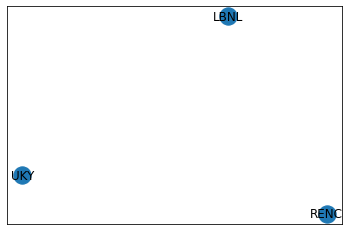

In [10]:
advertised_topology.draw()

## Create Slice

### Demo1 PTP

In [39]:
import fim.user as fu

print(fu.ComponentType.SmartNIC)

SmartNIC


{'capacities': {"bw": 25}, 'labels': , 'name': 'nic1-p1', 'type': TrunkPort}
{'capacities': {"bw": 25}, 'labels': , 'name': 'nic1-p1', 'type': TrunkPort}


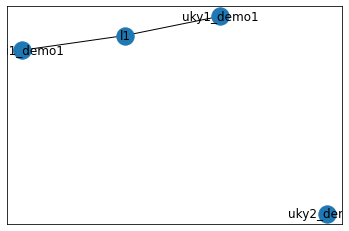

In [34]:
import fim.user as fu



# Create topology
t = fu.ExperimentTopology()

# Set capacities
cap = fu.Capacities()
cap.set_fields(core=4, ram=64, disk=500)

# Add nodes
node_uky1 = t.add_node(name='uky1_demo1', site='UKY')
node_uky1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')
nic_uky1 = node_uky1.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-5', name='nic1')

node_renc1 = t.add_node(name='renci1_demo1', site='RENC')
node_renc1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')
nic_renc1 = node_renc1.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-5', name='nic1')

node_uky2 = t.add_node(name='uky2_demo1', site='UKY')
node_uky2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')
nic_uky2 = node_uky2.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-5', name='nic1')


#print(nic_uky2)
# Add links

print(node_uky1.interfaces[nic_uky1.name+'-p1'])
print(node_renc1.interfaces[nic_renc1.name+'-p1'])

link1 = t.add_link(name='l1', interfaces=[node_uky1.interfaces[nic_uky1.name+'-p1'],node_renc1.interfaces[nic_renc1.name+'-p1']], ltype=fu.LinkType.Wave)



# Generate Slice Graph
#slice_graph = t.serialize()
t.draw()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
#status, reservations = orchestrator_proxy.create(token=fabric_id_token, slice_name='JupyterSlice2', slice_graph=slice_graph, ssh_key=ssh_key)

#print("Response Status {}".format(status))
#print("Reservations created {}".format(reservations))

In [ ]:
import fim.user as fu
# Create topology
t = fu.ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='RENC')

# Set capacities
cap = fu.Capacities()
cap.set_fields(core=4, ram=64, disk=500)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n1.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-5', name='nic1')

# Add node
n2 = t.add_node(name='n2', site='UKY')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n2.add_component(ctype=fu.ComponentType.GPU, model='Tesla T4', name='nic2')

# Add node
n3 = t.add_node(name='n3', site='LBNL')

# Set properties
n3.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n3.add_component(ctype=fu.ComponentType.GPU, model='Tesla T4', name='nic3')

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = orchestrator_proxy.create(token=fabric_id_token, slice_name='JupyterSlice2', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
print("Reservations created {}".format(reservations))

In [ ]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [ ]:
status, slices = orchestrator_proxy.slices(token=fabric_id_token)

print("Response Status {}".format(status))
print("Slices {}".format(slices))

## Query Slice

In [ ]:
status, slice_obj = orchestrator_proxy.get_slice(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(slice_obj))

In [ ]:
slice_obj.draw()

## Query Slivers

In [ ]:
status, reservations = orchestrator_proxy.slivers(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Reservations {}".format(reservations))

In [ ]:
# Set the Sliver ID from output of the above command by capturing reservation_id
sliver_id=reservations[0].reservation_id

## Query Sliver

In [ ]:
status, reservation = orchestrator_proxy.slivers(token=fabric_id_token, slice_id=slice_id, sliver_id=sliver_id)

print("Response Status {}".format(status))
print("Reservation {}".format(reservation))

## Slice Status

In [ ]:
status, slice_status = orchestrator_proxy.slice_status(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Slice Status {}".format(slice_status))

## Sliver Status

In [ ]:
status, reservation_status = orchestrator_proxy.sliver_status(token=fabric_id_token, slice_id=slice_id, sliver_id=sliver_id)

print("Response Status {}".format(status))
print("Reservation Status {}".format(reservation_status))

## Delete Slice

In [ ]:
status, result = orchestrator_proxy.delete(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))